In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import pydicom
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import measure
from skimage.transform import resize
import csv
import random
# Any results you write to the current directory are saved as output.

# ChexNet
[Stanford ChexNet](https://arxiv.org/abs/1711.05225)

### Radiology 
* The ***ChexNet*** paper reviews performance of AI versus 4 trained radiologists in diagnosing pneumonia. 
* **Pneumonia is a clinical diagnosis** — a **patient** will present with **fever and cough** , and can get a **chest Xray(CXR) to identify complications of pneumonia.** Patients will usually get **blood cultures** to **supplement diagnosis. Pneumonia on a CXR** is not easily distinguishable from other findings that fill the **alevolar spaces  —  specifically pus , blood , fluid or collapsed lung called atelectasis.**   
* The radiologists interpreting these studies can therefore use terms like infiltrates , consolidation and atelectasis interchangeably.

### Architeture of ChexNet( from [Stanford ChexNet](https://arxiv.org/abs/1711.05225))
* The **CheXNet algorithm** is a **121-layer deep 2D Convolutional Neural Network;** a **Densenet** after **Huang & Liu**. **The Densenet’s multiple residual connections reduce parameters and training time**, allowing a deeper, more powerful model. The model accepts a vectorized ***two-dimensional image of size 224 pixels by 224 pixels.***

* To improve trust in CheXNet’s output, a Class Activation Mapping (GRAD-CAM) heatmap was utilized after [Zhou et al](https://people.csail.mit.edu/bzhou/publication/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf). This allows the human user to “see” what areas of the radiograph provide the strongest activation of the Densenet for the highest probability label.  
* CheXNet is a 121-layer Dense Convolutional Network (DenseNet) (Huang et al., 2016) trained on the ChestX-ray 14 dataset. DenseNets improve flow of information and gradients through the network, making the optimization of very deep networks tractable. We replace the final fully connected layer with one that has a single output, after which we apply a sigmoid nonlinearity. The weights of the network are initialized with weights from a model pretrained on ImageNet (Deng et al., 2009). The network is trained end-to-end using Adam with standard parameters (ß1 = 0.9 and ß2 = 0.999) (Kingma & Ba, 2014). We train the model using minibatches of size 16. We use an initial learning rate of 0.001 that is decayed by a factor of 10 each time the validation loss plateaus after an epoch, and pick the model with the lowest validation loss.



# Display Images for review

In [2]:
# Forked from `https://www.kaggle.com/peterchang77/exploratory-data-analysis`
def parse_data(df, test = False):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    if not test:
      for n, row in df.iterrows():
          # --- Initialize patient entry into parsed 
          pid = row['patientId']
          if pid not in parsed:
              parsed[pid] = {
                  'dicom': 'data/stage_2_train_images/%s.dcm' % pid,
                  'label': row['Target'],
                  'boxes': []}

          # --- Add box if opacity is present
          if parsed[pid]['label'] == 1:
              parsed[pid]['boxes'].append(extract_box(row))
    else:
      for n, row in df.iterrows():
          # --- Initialize patient entry into parsed 
          pid = row['patientId']
          if pid not in parsed:
              parsed[pid] = {
                  'dicom': 'uploads/%s.dcm' % pid,
                  'label': row['Target'],
                  'boxes': []}

          # --- Add box if opacity is present
          if parsed[pid]['label'] == 1:
              parsed[pid]['boxes'].append(extract_box(row))

    return parsed


def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        #rgb = np.floor(np.random.rand(3) * 256).astype('int')
        rgb = [255, 251, 204] # Just use yellow
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=15)

    plt.imshow(im, cmap=plt.cm.gist_gray)
    plt.axis('off')

def overlay_box(im, box, rgb, stroke=2):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im


In [3]:
import tensorflow as tf
class generator(tf.keras.utils.Sequence):
    
    def __init__(self, folder, filenames, nodule_locations=None, batch_size=32, image_size=512, shuffle=True, predict=False, augment = False):
        self.folder = folder
        self.filenames = filenames
        self.nodule_locations = nodule_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.shuffle = shuffle
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains nodules
        if filename in nodule_locations:
            # loop through nodules
            for location in nodule_locations[filename]:
                # add 1's at the location of the nodule
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [4]:
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))
def create_downsample(channels, inputs):
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.LeakyReLU(0)(x)
    x = tf.keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.LeakyReLU(0)(x)
    x = tf.keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0)(x)
    x = tf.keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return tf.keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=5):
    # input
    inputs = tf.keras.Input(shape=(input_size, input_size, 1))
    x = tf.keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0)(x)
    x = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = tf.keras.layers.UpSampling2D(2**depth)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [34]:
def predict():
    folder = 'uploads'
    test_filenames = os.listdir(folder)
    print('n test samples:', len(test_filenames))
    k_=[]
    x_= []
    y_ =[]
    w_ =[]
    h_ =[]
    t_= []
    area = []
    # create test generator with predict flag set to True
    test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=256, shuffle=False, predict=True)
    submission_dict={}
    predictions =pd.DataFrame()
    for imgs, filenames in test_gen:
        # predict batch of images
        model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
        model.load_weights("model/model.h5")
        preds = model.predict(imgs)
        for pred, filename in zip(preds, filenames):
            # resize predicted mask
            pred = resize(pred, (1024, 1024), mode='reflect')
            # threshold predicted mask
            comp = pred[:, :, 0]>0.3
            # apply connected components
            comp = measure.label(comp)
            # apply bounding boxes
            predictionString = ''
            for region in measure.regionprops(comp):
                # retrieve x, y, height and width
                y, x, y2, x2 = region.bbox
                height = y2 - y
                k_.append(filename.split('.')[0])
                x_.append(x)
                y_.append(y)
                h_.append(height)
                width = x2 - x
                w_.append(width)
                conf = np.mean(pred[y:y+height, x:x+width])
                area.append(width*height)
                t_.append(conf)
        if len(x_) >= len(test_filenames):
            break
    test_predictions = pd.DataFrame()
    test_predictions['patientId'] = k_
    test_predictions['x'] =x_
    test_predictions['y'] =y_
    test_predictions['width'] =w_
    test_predictions['height']=h_
    test_predictions['Target'] = t_
    test_predictions['area'] = area

    return test_predictions


### testing shows that model is not trained enough to make predictions


n test samples: 35
                              patientId    x    y  width  height    Target  \
0  0d0a219a-f091-430b-a0c4-6a90faa1636c  257  320    254     255  0.309285   
1  0d1cf468-3791-40a7-8597-e0abb8b2d142  192  256    191     193  0.329026   
2  0d4ee901-841b-4693-8200-76d4cb1b2482  129  319    255     319  0.388568   

    area  
0  64770  
1  36863  
2  81345  
0    1.0
1    1.0
2    1.0
Name: Target, dtype: float64


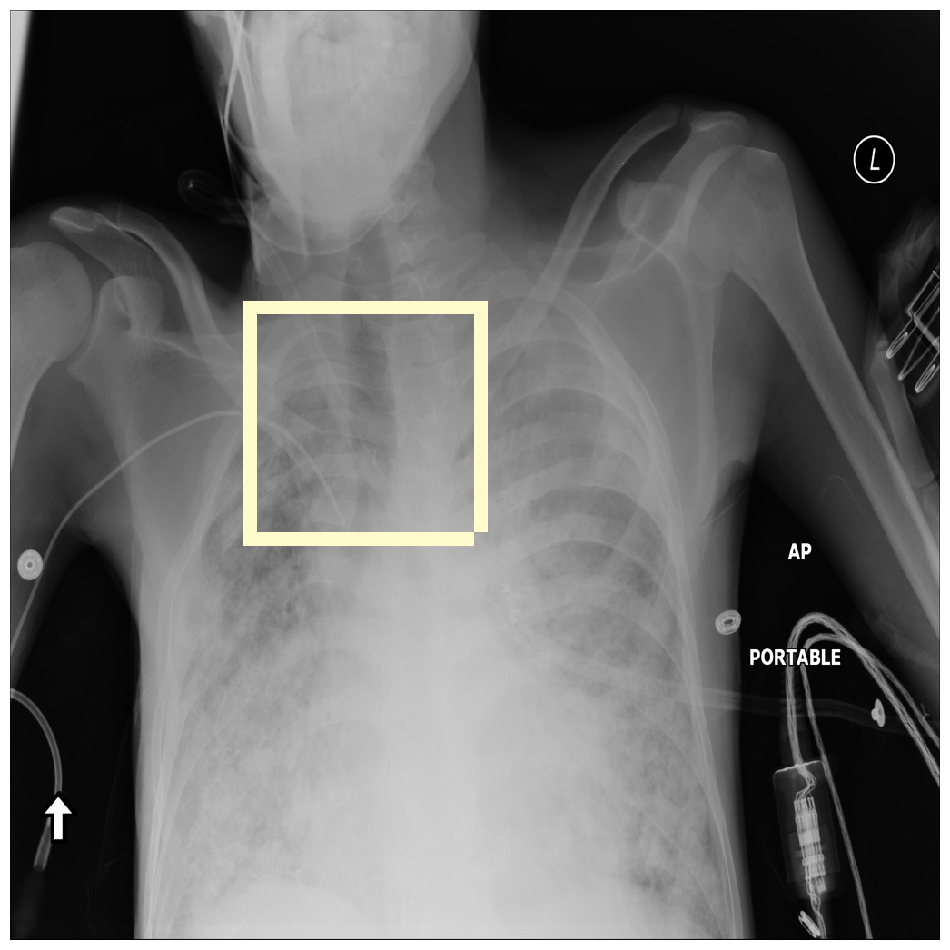

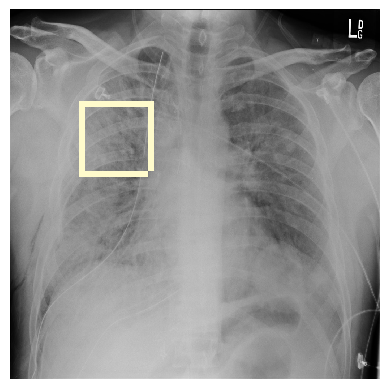

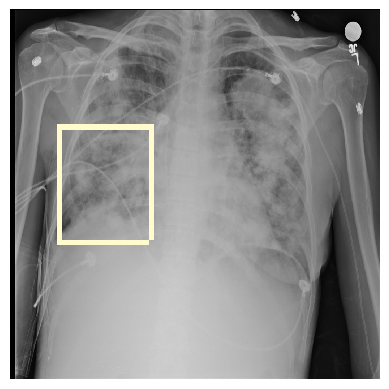

In [35]:
test_predictions = predict()
print(test_predictions)

test_predictions['Target'].values[test_predictions['Target'].values > 0.3] = 1
print(test_predictions['Target'])
parsed_test= parse_data(test_predictions, test = True)
plt.style.use('default')
fig=plt.figure(figsize=(12, 20))
for i in range(len(test_predictions)):
    file_name=draw(parsed_test[test_predictions['patientId'][i]])
    plt.show()